Same as Pulse_shaping_v1 notebook except:
- The IIR parameters are computed with formulas from desired time constants.
_ *There is a problem because the measured cuttoff frequency is not the spcified one???*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter


In [2]:
fs=100e6
label_digit=np.array(["fc=10MHz", "fc=15MHz", "fc=20MHz", "fc=30MHz"])
fc_digit=np.array([10e6, 15e6, 20e6, 30e6])
b_digit=1/(1+1/(2*np.pi*(fc_digit/fs)))
a_digit=b_digit-1


----------------------------------------------------------
y(n)=b.x(n)-a.y(n-1)
avec b=1/(1+Tau) et a=b-1
avec Tau=1/2.pi.fcn
fcn est la fréquence de coupure normalisée : fcn=fc/fs
Pour fs=100MHz on a donc :
fc=10MHz => b=0.385869545 et a=-0.614130455
fc=15MHz => b=0.485193601 et a=-0.514806399
fc=20MHz => b=0.556862724 et a=-0.443137276
fc=30MHz => b=0.653374214 et a=-0.346625786
----------------------------------------------------------


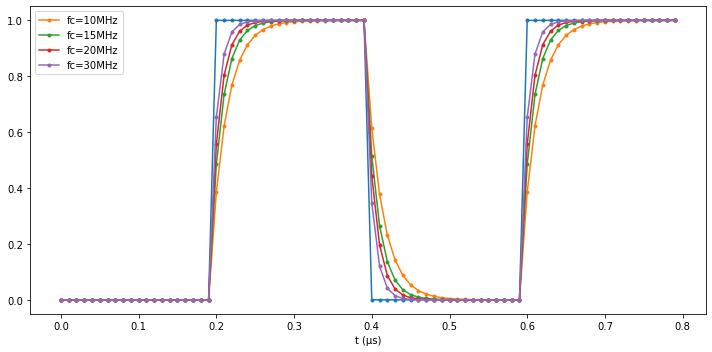

In [3]:
f_ratio=20  # Ratio between sampling frequency and frow
frow=fs/f_ratio
Nrows=4
sig=np.zeros(f_ratio*Nrows)
t=np.arange(f_ratio*Nrows)/(f_ratio*frow)
sig[f_ratio:f_ratio*2]=np.ones(f_ratio)
sig[3*f_ratio:4*f_ratio*2]=np.ones(f_ratio)

print("----------------------------------------------------------")
print("y(n)=b.x(n)-a.y(n-1)")
print("avec b=1/(1+Tau) et a=b-1")
print("avec Tau=1/2.pi.fcn")
print("fcn est la fréquence de coupure normalisée : fcn=fc/fs")
print("Pour fs=100MHz on a donc :")
for i in range(len(fc_digit)):
    print("fc={0:2.0f}MHz => b={1:10.9f} et a={2:10.9f}".format(fc_digit[i]/1e6, b_digit[i], b_digit[i]-1))
print("----------------------------------------------------------")

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
ax.plot(t*1e6,sig, marker='.')
for i in range(len(fc_digit)):
    ax.plot(t*1e6,lfilter(np.array([b_digit[i]]), np.array([1,a_digit[i]]), sig), marker='.', label=label_digit[i])
ax.set_xlabel('t (µs)')
ax.legend(loc='best')
fig.tight_layout()


In [4]:
def apply_filter(sig, a):
    return(lfilter([a+1],[1, a], sig))

In [5]:
def switch2analog(sig, ratio_analog=1000):
    """
    This function fakes a perfect digital to analogue convertion 
    by oversampling input values.
    """
    sig_analog=np.zeros(len(sig)*ratio_analog)
    for i in range(len(sig)):
        sig_analog[i*ratio_analog:(i+1)*ratio_analog]=sig[i]
    return(sig_analog)

In [8]:
def compare_plot(sig, a_dig1, a_dig2, text1='', text2=''):
    ratio_analog=1000

    t_analog=np.arange(f_ratio*Nrows*ratio_analog)/(f_ratio*ratio_analog*frow)
    sig_analog=switch2analog(sig,ratio_analog)
    sig1_analog=switch2analog(apply_filter(sig,a_dig1))
    sig2_analog=switch2analog(apply_filter(sig,a_dig2))

    xmini, xmaxi=0.18, 0.30
    ymini, ymaxi=-0.1, 1.1
    grid_x_ticks = np.arange(xmini, xmaxi, 0.01)
    
    fig=plt.figure(figsize=(14,14))

    # applying analog filter
    label_analog=np.array(["fc=10MHz", "fc=20MHz", "fc=30MHz", "fc=50MHz"])
    fc_analog=np.array([10e6, 20e6, 30e6, 50e6])
    b_analog=1/(1+1/(2*np.pi*(fc_analog/(fs*ratio_analog))))
    a_analog=b_analog-1
    sig_analog_filt_10MHz=apply_filter(sig_analog, a_analog[0])
    sig1_analog_filt_10MHz=apply_filter(sig1_analog, a_analog[0])
    sig1_analog_filt_20MHz=apply_filter(sig1_analog, a_analog[1])
    sig1_analog_filt_30MHz=apply_filter(sig1_analog, a_analog[2])
    sig1_analog_filt_50MHz=apply_filter(sig1_analog, a_analog[3])


    ax1=fig.add_subplot(3,2,1)
    # Drawing zoom area
    ax1.plot([xmini,xmini],[ymini, ymaxi], '-k', linewidth=2)
    ax1.plot([xmaxi,xmaxi],[ymini, ymaxi], '-k', linewidth=2)
    ax1.plot([xmini,xmaxi],[ymini, ymini], '-k', linewidth=2)
    ax1.plot([xmini,xmaxi],[ymaxi, ymaxi], '-k', linewidth=2)

    ax1.plot(t_analog*1e6, sig_analog, label='Square')
    ax1.plot(t_analog*1e6, sig1_analog, label='Square+digital LPF '+text1)
    ax1.plot(t_analog*1e6, sig_analog_filt_10MHz, color='k', label='Square+analog LPF @ 10MHz')
    ax1.plot(t_analog*1e6, sig1_analog_filt_10MHz, color='r', label='Square+digital LPF '+text1+'+analog LPF @ 10MHz')
    ax1.plot(t_analog*1e6, sig1_analog_filt_20MHz, label='Square+digital LPF '+text1+'+analog LPF @ 20MHz')
    ax1.plot(t_analog*1e6, sig1_analog_filt_30MHz, color='blue', label='Square+digital LPF'+text1+'+analog LPF @ 30MHz')
    ax1.plot(t_analog*1e6, sig1_analog_filt_50MHz, label='Square+digital LPF'+text1+'+analog LPF @ 50MHz')
    ax1.legend(loc='best')
    ax1.set_xlabel('t (µs)')
    ax1.set_xlim([0.15, 0.55])
    ax1.set_ylim([ymini, ymaxi])
    ax1.grid(color='k', linestyle=':', linewidth=0.5)

    ax2=fig.add_subplot(3,2,3)
    ax2.plot(t_analog*1e6, sig_analog, label='Square')
    ax2.plot(t_analog*1e6, sig1_analog, label='Square+digital LPF '+text1)
    ax2.plot(t_analog*1e6, sig_analog_filt_10MHz, color='k', label='Square+analog LPF @ 10MHz')
    ax2.plot(t_analog*1e6, sig1_analog_filt_10MHz, color='r', label='Square+digital LPF '+text1+'+analog LPF @ 10MHz')
    ax2.plot(t_analog*1e6, sig1_analog_filt_20MHz, label='Square+digital LPF '+text1+'+analog LPF @ 20MHz')
    ax2.plot(t_analog*1e6, sig1_analog_filt_30MHz, color='blue', label='Square+digital LPF '+text1+'+analog LPF @ 30MHz')
    ax2.plot(t_analog*1e6, sig1_analog_filt_50MHz, label='Square+digital LPF '+text1+'+analog LPF @ 50MHz')
    ax2.legend(loc='best')
    ax2.set_xlabel('t (µs)')
    ax2.set_xlim([xmini, xmaxi])
    ax2.set_xticks(grid_x_ticks, minor=True)
    ax2.grid(which='both', alpha=0.8, linestyle='--')


    ax3=fig.add_subplot(3,2,2)
    # Drawing zoom area
    ax3.plot([xmini,xmini],[ymini, ymaxi], '-k', linewidth=2)
    ax3.plot([xmaxi,xmaxi],[ymini, ymaxi], '-k', linewidth=2)
    ax3.plot([xmini,xmaxi],[ymini, ymini], '-k', linewidth=2)
    ax3.plot([xmini,xmaxi],[ymaxi, ymaxi], '-k', linewidth=2)

    sig2_analog_filt_10MHz=apply_filter(sig2_analog, a_analog[0])
    sig2_analog_filt_20MHz=apply_filter(sig2_analog, a_analog[1])
    sig2_analog_filt_30MHz=apply_filter(sig2_analog, a_analog[2])
    sig2_analog_filt_50MHz=apply_filter(sig2_analog, a_analog[3])

    ax3.plot(t_analog*1e6, sig_analog, label='Square')
    ax3.plot(t_analog*1e6, sig2_analog, label='Square+digital LPF '+text2)
    ax3.plot(t_analog*1e6, sig_analog_filt_10MHz, color='k', label='Square+analog LPF @ 10MHz')
    ax3.plot(t_analog*1e6, sig2_analog_filt_10MHz, color='r', label='Square+digital LPF '+text2+'+analog LPF @ 10MHz')
    ax3.plot(t_analog*1e6, sig2_analog_filt_20MHz, label='Square+digital LPF '+text2+'+analog LPF @ 20MHz')
    ax3.plot(t_analog*1e6, sig2_analog_filt_30MHz, color='blue', label='Square+digital LPF '+text2+'+analog LPF @ 30MHz')
    ax3.plot(t_analog*1e6, sig2_analog_filt_50MHz, label='Square+digital LPF '+text2+'+analog LPF @ 50MHz')
    ax3.legend(loc='best')
    ax3.set_xlabel('t (µs)')
    ax3.set_xlim([0.15, 0.55])
    ax3.set_ylim([ymini, ymaxi])
    ax3.grid(color='k', linestyle=':', linewidth=0.5)


    ax4=fig.add_subplot(3,2,4)
    ax4.plot(t_analog*1e6, sig_analog, label='Square')
    ax4.plot(t_analog*1e6, sig2_analog, label='Square+digital LPF '+text2)
    ax4.plot(t_analog*1e6, sig_analog_filt_10MHz, color='k', label='Square+analog LPF @ 10MHz')
    ax4.plot(t_analog*1e6, sig2_analog_filt_10MHz, color='r', label='Square+digital LPF '+text2+'+analog LPF @ 10MHz')
    ax4.plot(t_analog*1e6, sig2_analog_filt_20MHz, label='Square+digital LPF '+text2+'+analog LPF @ 20MHz')
    ax4.plot(t_analog*1e6, sig2_analog_filt_30MHz, color='blue', label='Square+digital LPF '+text2+'+analog LPF @ 30MHz')
    ax4.plot(t_analog*1e6, sig2_analog_filt_50MHz, label='Square+digital LPF '+text2+'+analog LPF @ 50MHz')
    ax4.legend(loc='best')
    ax4.set_xlabel('t (µs)')
    ax4.set_xlim([xmini, xmaxi])
    ax4.set_xticks(grid_x_ticks, minor=True)
    ax4.grid(which='both', alpha=0.8, linestyle='--')

    ax5=fig.add_subplot(3,2,5)
    ax5.plot(t_analog*1e6, sig_analog_filt_10MHz, color='k', label='Square+analog LPF @ 10MHz')
    ax5.plot(t_analog*1e6, sig1_analog_filt_10MHz,':', color='r', label='Square+digital LPF '+text1+'+analog LPF @ 10MHz')
    ax5.plot(t_analog*1e6, sig2_analog_filt_10MHz, color='r', label='Square+digital LPF '+text2+'+analog LPF @ 10MHz')
    ax5.legend(loc='best')
    ax5.set_xlabel('t (µs)')
    ax5.set_xlim([xmini, xmaxi])
    ax5.set_xticks(grid_x_ticks, minor=True)
    ax5.grid(which='both', alpha=0.8, linestyle='--')
    
    ax6=fig.add_subplot(3,2,6)
    ax6.plot(t_analog*1e6, sig_analog_filt_10MHz, color='k', label='Square+analog LPF @ 10MHz')
    ax6.plot(t_analog*1e6, sig1_analog_filt_30MHz,':', color='blue', label='Square+digital LPF '+text1+'+analog LPF @ 30MHz')
    ax6.plot(t_analog*1e6, sig2_analog_filt_30MHz, color='blue', label='Square+digital LPF '+text2+'+analog LPF @ 30MHz')
    ax6.legend(loc='best')
    ax6.set_xlabel('t (µs)')
    ax6.set_xlim([xmini, xmaxi])
    ax6.set_xticks(grid_x_ticks, minor=True)
    ax6.grid(which='both', alpha=0.8, linestyle='--')

    fig.tight_layout()
    plt.savefig('pulse_shaping_tests.jpg', dpi=120, bbox_inches='tight')


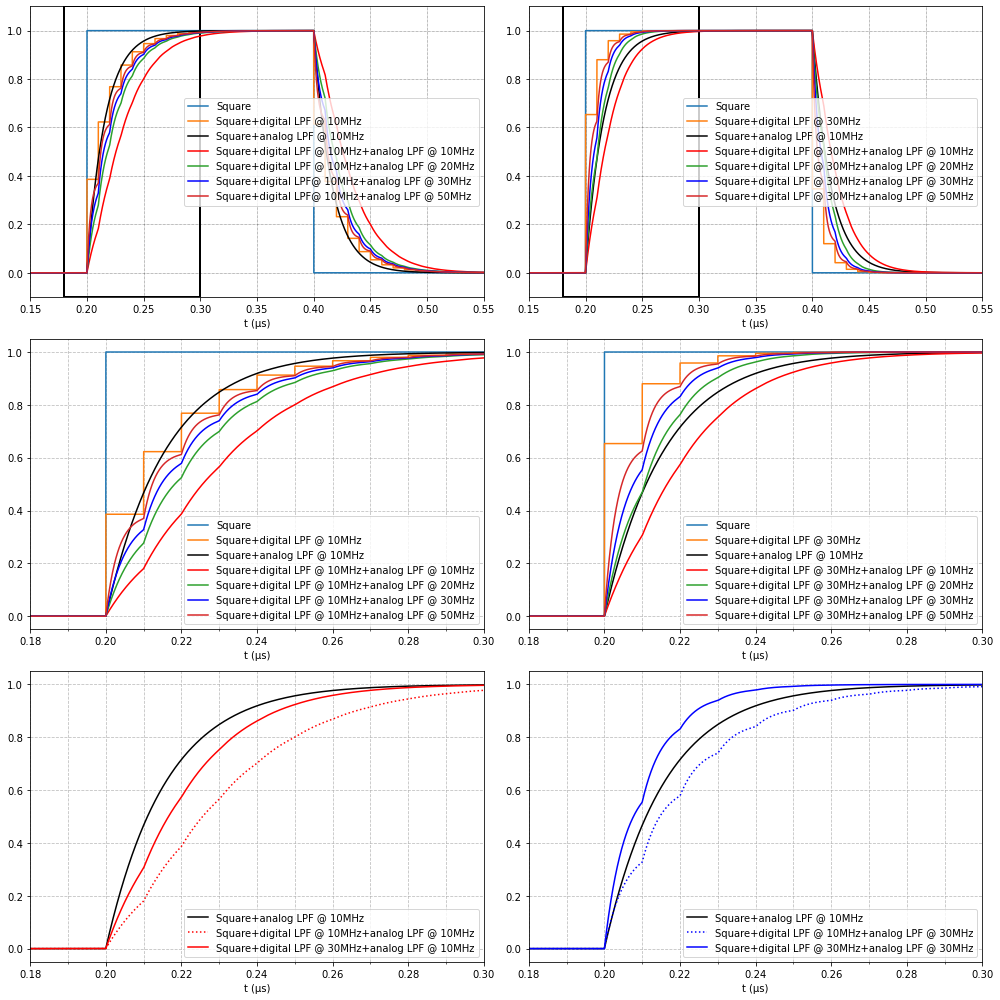

In [9]:
compare_plot(sig, a_digit[0], a_digit[3], '@ 10MHz', '@ 30MHz')

In [14]:
def dirac(n):
    """ dirac(n):
    Rend une impulsion de Dirac de longueur n """
    d=np.zeros(n)
    d[0]=1
    return d

def freq_analysis(a,Fs,Fmax=50e6,name=''):
    n=10000000
    h=apply_filter(dirac(n),a)

    # Calcul de la réponse en fréquence
    M=1000000
    H=np.fft.fftshift(np.fft.fft(h,M))   # On utilise ffshift pour centrer la représentation sur 0
    H=abs(H[int(M/2):])

    f=np.arange(M/2)/M*Fs
    module_db=20*np.log10(H/H[0])

    fc=f[np.where(module_db <= -3)][0]
    #print("Cutoff frequency: {0:6.3} MHz +/- {1:6.3} kHz".format(fc/1e6, Fs/M/1e3))

    fmini=100e3
    fig=plt.figure(4)   # Et affichage
    plt.semilogx(f, module_db, label=u"cutoff frequency ={0:6.3} MHz".format(fc/1e6))
    plt.plot([fc,fc],[-50,-3],'--', color='k')
    plt.plot([fmini,fc],[-3,-3],'--', color='k')
    plt.xlabel(u"Frequency")
    plt.ylabel(u"Attenuation (dB)")
    plt.title("Frequency response"+name)
    plt.legend(loc="best")
    plt.grid(b=True)
    plt.xlim([fmini, Fmax])
    plt.ylim([-6, 1])
    fig.tight_layout()   # évite le recouvrement des titles et labels


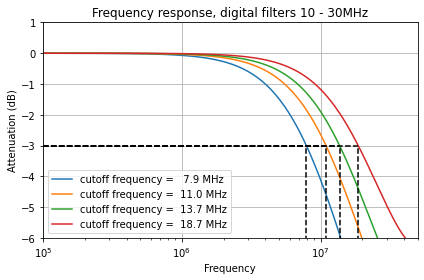

In [15]:
freq_analysis(a_digit[0],fs,fs/2)
freq_analysis(a_digit[1],fs,fs/2)
freq_analysis(a_digit[2],fs,fs/2)
freq_analysis(a_digit[3],fs,fs/2,', digital filters 10 - 30MHz')

plt.savefig('f_response_digital_filters.jpg', dpi=120, bbox_inches='tight')


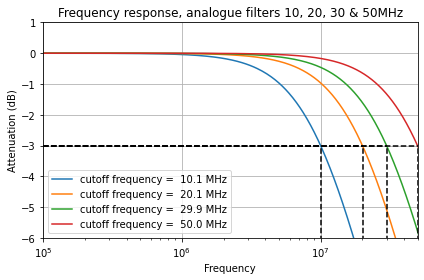

In [25]:
a_analog_10MHz=0.99937
a_analog_20MHz=0.99874
a_analog_30MHz=0.99812
a_analog_50MHz=0.99686
freq_analysis(a_analog_10MHz,fs*ratio_analog,fs/2)
freq_analysis(a_analog_20MHz,fs*ratio_analog,fs/2)
freq_analysis(a_analog_30MHz,fs*ratio_analog,fs/2)
freq_analysis(a_analog_50MHz,fs*ratio_analog,fs/2,', analogue filters 10, 20, 30 & 50MHz')

plt.savefig('f_response_analog_filters.jpg', dpi=120, bbox_inches='tight')

In [34]:
def compare_plot2(sig, a_dig1, a_dig2, text1='', text2=''):
    t_analog=np.arange(f_ratio*Nrows*ratio_analog)/(f_ratio*ratio_analog*frow)
    sig_analog=switch2analog(sig,ratio_analog)
    sig1_analog=switch2analog(apply_filter(sig,a_dig1))
    sig2_analog=switch2analog(apply_filter(sig,a_dig2))

    xmini, xmaxi=0.18, 0.30
    ymini, ymaxi=0.99, 1.001
    grid_x_ticks = np.arange(xmini, xmaxi, 0.01)
    
    fig=plt.figure(figsize=(14,6))

    # applying analog filter
    sig_analog_filt_10MHz=apply_filter(sig_analog, a_analog_10MHz)
    
    ax1=fig.add_subplot(2,1,1)

    sig1_analog_filt_10MHz=apply_filter(sig1_analog, a_analog_10MHz)
    sig1_analog_filt_20MHz=apply_filter(sig1_analog, a_analog_20MHz)
    sig1_analog_filt_30MHz=apply_filter(sig1_analog, a_analog_30MHz)
    sig1_analog_filt_50MHz=apply_filter(sig1_analog, a_analog_50MHz)

    ax1.plot(t_analog*1e6, sig_analog, label='Square')
    ax1.plot(t_analog*1e6, sig1_analog, label='Square+digital LPF '+text1)
    ax1.plot(t_analog*1e6, sig_analog_filt_10MHz, color='k', label='Square+analog LPF @ 10MHz')
    ax1.plot(t_analog*1e6, sig1_analog_filt_10MHz, color='r', label='Square+digital LPF '+text1+'+analog LPF @ 10MHz')
    ax1.plot(t_analog*1e6, sig1_analog_filt_20MHz, label='Square+digital LPF '+text1+'+analog LPF @ 20MHz')
    ax1.plot(t_analog*1e6, sig1_analog_filt_30MHz, color='blue', label='Square+digital LPF'+text1+'+analog LPF @ 30MHz')
    ax1.plot(t_analog*1e6, sig1_analog_filt_50MHz, label='Square+digital LPF'+text1+'+analog LPF @ 50MHz')
    ax1.legend(loc='best')
    ax1.set_xlabel('t (µs)')
    ax1.set_xlim([0.15, 0.55])
    ax1.set_ylim([ymini, ymaxi])
    ax1.grid(color='k', linestyle=':', linewidth=0.5)

    ax3=fig.add_subplot(2,1,2)

    sig2_analog_filt_10MHz=apply_filter(sig2_analog, a_analog_10MHz)
    sig2_analog_filt_20MHz=apply_filter(sig2_analog, a_analog_20MHz)
    sig2_analog_filt_30MHz=apply_filter(sig2_analog, a_analog_30MHz)
    sig2_analog_filt_50MHz=apply_filter(sig2_analog, a_analog_50MHz)

    ax3.plot(t_analog*1e6, sig_analog, label='Square')
    ax3.plot(t_analog*1e6, sig2_analog, label='Square+digital LPF '+text2)
    ax3.plot(t_analog*1e6, sig_analog_filt_10MHz, color='k', label='Square+analog LPF @ 10MHz')
    ax3.plot(t_analog*1e6, sig2_analog_filt_10MHz, color='r', label='Square+digital LPF '+text2+'+analog LPF @ 10MHz')
    ax3.plot(t_analog*1e6, sig2_analog_filt_20MHz, label='Square+digital LPF '+text2+'+analog LPF @ 20MHz')
    ax3.plot(t_analog*1e6, sig2_analog_filt_30MHz, color='blue', label='Square+digital LPF '+text2+'+analog LPF @ 30MHz')
    ax3.plot(t_analog*1e6, sig2_analog_filt_50MHz, label='Square+digital LPF '+text2+'+analog LPF @ 50MHz')
    ax3.legend(loc='best')
    ax3.set_xlabel('t (µs)')
    ax3.set_xlim([0.15, 0.55])
    ax3.set_ylim([ymini, ymaxi])
    ax3.grid(color='k', linestyle=':', linewidth=0.5)
    
    fig.tight_layout()   # évite le recouvrement des titles et labels
    
    plt.savefig('pulse_shaping_tests_zoom_plateau.jpg', dpi=120, bbox_inches='tight')



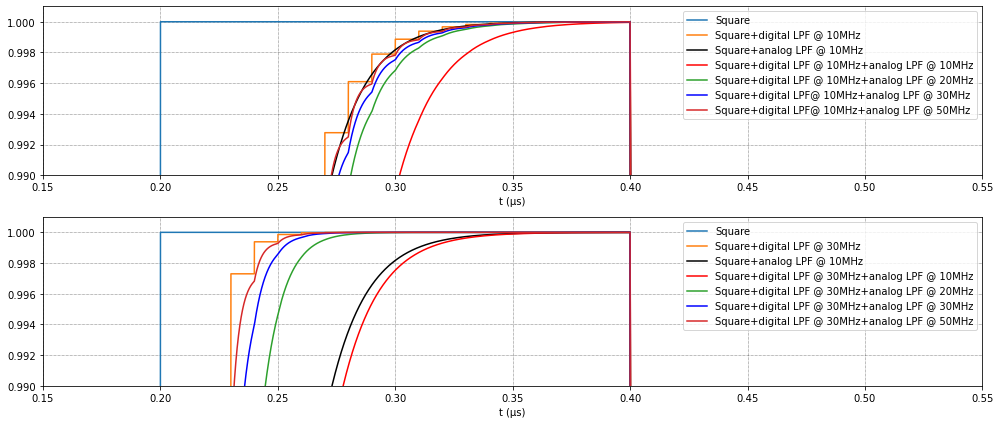

In [35]:
compare_plot2(sig, a_digit_10MHz, a_digit_30MHz, '@ 10MHz', '@ 30MHz')

In [34]:
def compare_plot3(sig, a_ana, a_dig1, a_dig2, a_dig3, a_dig4, texta='', textd1='', textd2='', textd3='', textd4=''):
    t_analog=np.arange(f_ratio*Nrows*ratio_analog)/(f_ratio*ratio_analog*frow)
    """
    This function makes plots to compare the impact of the combination of different digital filters 
    with an analogue filter.
    """

    # Applying digital filters to square signal
    sig_df1=apply_filter(sig,a_dig1)
    sig_df2=apply_filter(sig,a_dig2)
    sig_df3=apply_filter(sig,a_dig3)
    sig_df4=apply_filter(sig,a_dig4)


    # moving to analogue domain (i.e. quasi infinite sampling)
    sig_analog=switch2analog(sig,ratio_analog)
    sig_df1_analog=switch2analog(sig_df1,ratio_analog)
    sig_df2_analog=switch2analog(sig_df2,ratio_analog)
    sig_df3_analog=switch2analog(sig_df3,ratio_analog)
    sig_df4_analog=switch2analog(sig_df4,ratio_analog)


    # Applying analogue filter
    a_analog_10MHz=0.99937
    sig_analog_af=apply_filter(sig_analog,a_analog_10MHz)
    sig_df1_analog_af=apply_filter(sig_df1_analog,a_ana)
    sig_df2_analog_af=apply_filter(sig_df2_analog,a_ana)
    sig_df3_analog_af=apply_filter(sig_df3_analog,a_ana)
    sig_df4_analog_af=apply_filter(sig_df4_analog,a_ana)

    xmini, xmaxi=0.18, 0.30
    ymini, ymaxi=-0.1, 1.1
    grid_x_ticks = np.arange(xmini, xmaxi, 0.01)
    
    fig=plt.figure(figsize=(10,8))
    
    ax1=fig.add_subplot(2,1,1)
    ax1.plot([xmini,xmini],[ymini, ymaxi], '-k', linewidth=2)
    ax1.plot([xmaxi,xmaxi],[ymini, ymaxi], '-k', linewidth=2)
    ax1.plot([xmini,xmaxi],[ymini, ymini], '-k', linewidth=2)
    ax1.plot([xmini,xmaxi],[ymaxi, ymaxi], '-k', linewidth=2)

    ax1.plot(t_analog*1e6, sig_analog, label='Square')
    ax1.plot(t_analog*1e6, sig_analog_af, color='k', label='Square+analog LPF @ 10MHz')
    ax1.plot(t_analog*1e6, sig_df1_analog_af, color='r', label='Square+digital LPF '+textd1+'+analog LPF '+texta)
    ax1.plot(t_analog*1e6, sig_df2_analog_af, color='g', label='Square+digital LPF '+textd2+'+analog LPF '+texta)
    ax1.plot(t_analog*1e6, sig_df3_analog_af, color='b', label='Square+digital LPF '+textd3+'+analog LPF '+texta)
    ax1.plot(t_analog*1e6, sig_df4_analog_af, color='orange', label='Square+digital LPF '+textd4+'+analog LPF '+texta)

    ax1.legend(loc='best')
    ax1.set_xlabel('t (µs)')
    ax1.set_xlim([0.15, 0.55])
    ax1.set_ylim([ymini, ymaxi])
    ax1.grid(color='k', linestyle=':', linewidth=0.5)

    ax2=fig.add_subplot(2,1,2)

    ax2.plot(t_analog*1e6, sig_analog, label='Square')
    ax2.plot(t_analog*1e6, sig_analog_af, color='k', label='Square+analog LPF @ 10MHz')
    ax2.plot(t_analog*1e6, sig_df1_analog_af, color='r', label='Square+digital LPF '+textd1+'+analog LPF '+texta)
    ax2.plot(t_analog*1e6, sig_df2_analog_af, color='g', label='Square+digital LPF '+textd2+'+analog LPF '+texta)
    ax2.plot(t_analog*1e6, sig_df3_analog_af, color='b', label='Square+digital LPF '+textd3+'+analog LPF '+texta)
    ax2.plot(t_analog*1e6, sig_df4_analog_af, color='orange', label='Square+digital LPF '+textd4+'+analog LPF '+texta)

    ax2.legend(loc='best')
    ax2.set_xlabel('t (µs)')
    ax2.set_xlim([xmini, xmaxi])
    ax2.set_ylim([ymini, ymaxi])
    ax2.set_xticks(grid_x_ticks, minor=True)
    ax2.grid(which='both', alpha=0.8, linestyle='--')

    fig.tight_layout()   # évite le recouvrement des titles et labels


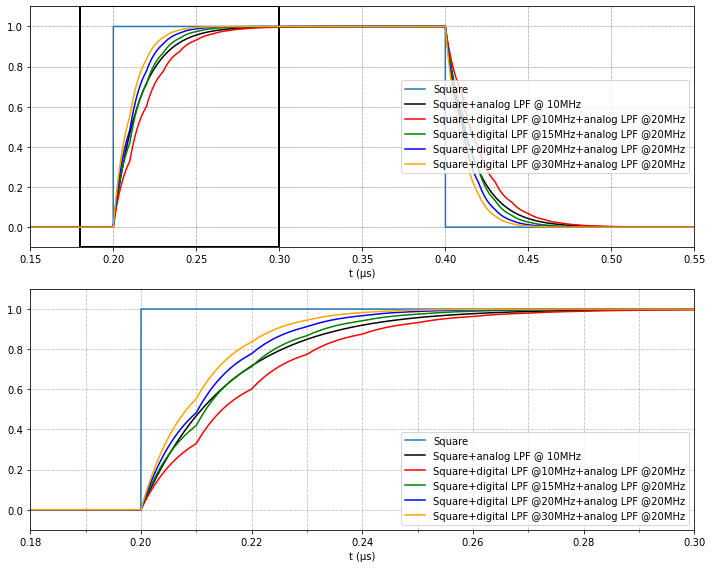

In [39]:
compare_plot3(sig, a_analog_20MHz, a_digit_10MHz, a_digit_15MHz, a_digit_20MHz, a_digit_30MHz, \
              '@20MHz', '@10MHz', '@15MHz', '@20MHz', '@30MHz')
plt.savefig('impact_of_dig_filter_analog_filter@20MHz.jpg', dpi=120, bbox_inches='tight')

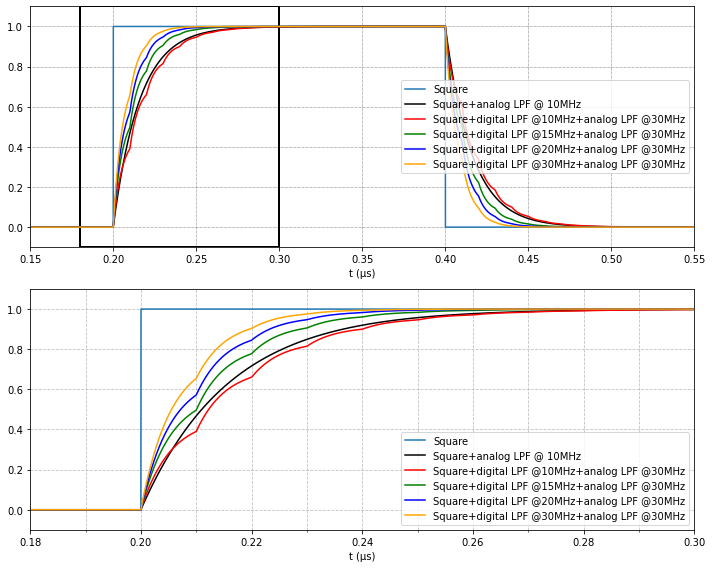

In [40]:
compare_plot3(sig, a_analog_30MHz, a_digit_10MHz, a_digit_15MHz, a_digit_20MHz, a_digit_30MHz, \
              '@30MHz', '@10MHz', '@15MHz', '@20MHz', '@30MHz')
plt.savefig('impact_of_dig_filter_analog_filter@30MHz.jpg', dpi=120, bbox_inches='tight')

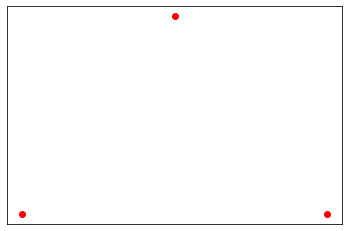

In [88]:
nval=3
r=20
tdm5=np.zeros(nval)
tdm5[1]=1

fig, ax = plt.subplots(figsize=(6, 4))
#ax.plot(tdm5, color='r', marker='o')
ax.plot(tdm5, 'o', color='r')
ax.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set(xticklabels=[])  # remove the tick labels
ax.tick_params(bottom=False)  # remove the ticks


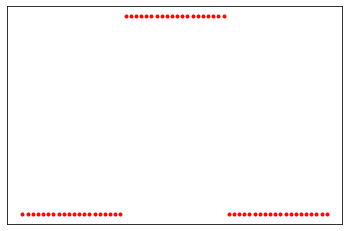

In [98]:
tdm100=np.zeros(nval*r)
for i in range(nval):
    tdm100[i*r:(i+1)*r]=tdm5[i]

fig, ax = plt.subplots(figsize=(6, 4))
#ax.plot(tdm100, color='r', marker='o')
ax.plot(tdm100, '.', color='r')
ax.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set(xticklabels=[])  # remove the tick labels
ax.tick_params(bottom=False)  # remove the ticks


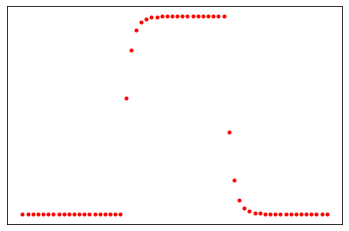

In [95]:
tdm_dlpf=apply_filter(tdm100,a_digit_15MHz)

fig, ax = plt.subplots(figsize=(6, 4))
#ax.plot(tdm_dlpf, color='r', marker='o')
ax.plot(tdm_dlpf, '.', color='r')
ax.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set(xticklabels=[])  # remove the tick labels
ax.tick_params(bottom=False)  # remove the ticks


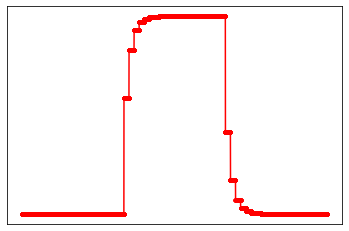

In [100]:
tdm_dac=switch2analog(tdm_dlpf,1000)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(tdm_dac, color='r', marker='.')
#ax.plot(tdm_dac, '.', color='r')
ax.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set(xticklabels=[])  # remove the tick labels
ax.tick_params(bottom=False)  # remove the ticks


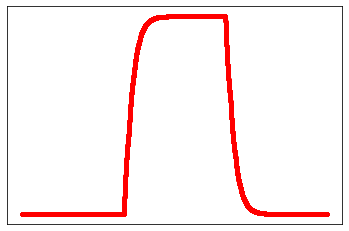

In [78]:
tdm_out=apply_filter(tdm_dac,a_analog_20MHz)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(tdm_out, color='r', marker='.')
ax.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set(xticklabels=[])  # remove the tick labels
ax.tick_params(bottom=False)  # remove the ticks


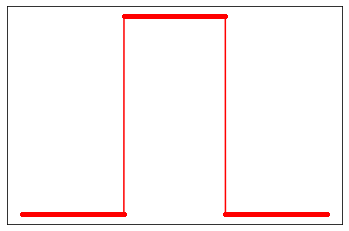

In [99]:
tdm_DAC5MHz=switch2analog(tdm5,20*1000)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(tdm_DAC5MHz, color='r', marker='.')
#ax.plot(tdm_DAC5MHz, '.', color='r')
ax.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set(xticklabels=[])  # remove the tick labels
ax.tick_params(bottom=False)  # remove the ticks


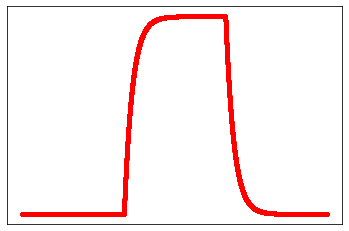

In [94]:
a_analog_10MHz=0.99937
tdm_out2=apply_filter(tdm_DAC5MHz,a_analog_10MHz)

fig, ax = plt.subplots(figsize=(6, 4))
#ax.plot(tdm_out2, color='r', marker='.')
ax.plot(tdm_out2, '.', color='r')
ax.set(yticklabels=[])  # remove the tick labels
ax.tick_params(left=False)  # remove the ticks
ax.set(xticklabels=[])  # remove the tick labels
ax.tick_params(bottom=False)  # remove the ticks

